In [1]:
import requests
import timm

model = timm.create_model("resnet50", pretrained=True)
# model = resnet50(pretrained=True)


# Load ImageNet class index
def load_imagenet_classes():
    IMAGENET_CLASSES = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(IMAGENET_CLASSES)
    class_idx = response.json()
    return class_idx

imagenet_classes = load_imagenet_classes()

In [2]:
import cv2
import numpy as np

image_path = 'cat-dog-1.jpeg'

# Read the image in RGB format (by default OpenCV uses BGR)
rgb_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

# Normalize the pixel values
rgb_img = np.float32(rgb_img) / 255

# Resize the image to 224x224
rgb_img_resized = cv2.resize(rgb_img, (224, 224))



In [3]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def read_image_and_preprocess(image_path):
    img = Image.open(image_path).convert('RGB')  # Load image and ensure it is in RGB format
    transform = transforms.Compose([
        transforms.Resize((224,224)),  # Resize the smaller edge to 256
        # transforms.(224),  # Crop a center square of 224x224 pixels
        transforms.ToTensor(),  # Convert image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    img_tensor = transform(img).unsqueeze(0)  # Apply the transformations and add batch dimension
    return img_tensor

# Example usage
img_tensor = read_image_and_preprocess(image_path)


In [4]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2

target_layers = [model.layer4[-1]]
input_tensor = img_tensor


# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

output_idx = torch.argmax(model(img_tensor))

print("The image is: ", imagenet_classes[output_idx])


targets = [ClassifierOutputTarget(output_idx)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)



The image is:  Golden Retriever


In [5]:
grayscale_cam

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.10667358, 0.10667358, 0.10667358, ..., 0.        ,
         0.        , 0.        ],
        [0.10667358, 0.10667358, 0.10667358, ..., 0.        ,
         0.        , 0.        ],
        [0.10667358, 0.10667358, 0.10667358, ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [6]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img_resized, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

ValueError: operands could not be broadcast together with shapes (224,335,3) (224,224,3) 

In [8]:
rgb_img_resized.shape, grayscale_cam.shape

((224, 224, 3), (224, 335))

In [57]:
visualization.shape

(224, 224, 3)

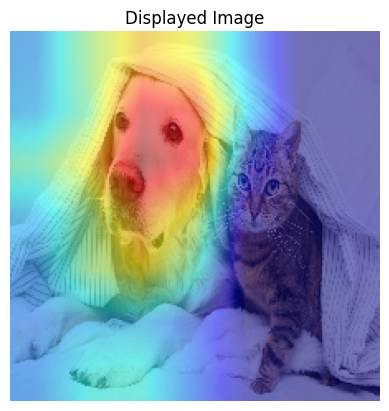

In [58]:
import matplotlib.pyplot as plt

# Assuming 'visualization' is your image array with shape (224, 224, 3)
plt.imshow(visualization)
plt.title('Displayed Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [21]:
output_tensors = model(img_tensor)

In [22]:
val, idx = torch.topk(output_tensors, 10)

for id in idx[0]:
    print(id, imagenet_classes[id])

tensor(264) Cardigan Welsh Corgi
tensor(173) Ibizan Hound
tensor(172) Whippet
tensor(138) bustard
tensor(218) Welsh Springer Spaniel
tensor(161) Basset Hound
tensor(215) Brittany Spaniel
tensor(263) Pembroke Welsh Corgi
tensor(238) Greater Swiss Mountain Dog
tensor(993) gyromitra


In [22]:
val, idx

(tensor([[6.8989, 6.6435, 5.4799, 5.3896, 5.2145, 5.1985, 4.9713, 4.9667, 4.9110,
          4.9059]], grad_fn=<TopkBackward0>),
 tensor([[208, 207, 700, 588, 852, 750, 534, 897, 539, 805]]))